In [48]:
import pandas as pd
import numpy as np

import tiktoken
import os
import re
import tensorflow as tf
import tqdm
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

import sys
import os
import sys
import os

# Add "utils/" to sys.path
repo_dir = os.getcwd()
custom_files_dir = os.path.join(repo_dir, 'utils')
sys.path.append(custom_files_dir)

# Data Preprocessing

In [49]:
# Downloaded from "SMS Spam Collection" UC Irvine
spam_df = pd.read_csv('Classification_finetuning/spam.csv', sep=',', header=None, names=['Label', 'Text', 'a', 'b', 'c'], encoding_errors='ignore')
spam_df

,Label,Text,a,b,c
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will _ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [50]:
print(spam_df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
spam_df['Label'] = spam_df['Label'].map({'ham': 0, 'spam': 1})

# training: 70%
# validation: 10%
# testing: 20%
def random_split(df, train_frac, validation_frac):
  # Shuffle
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)

  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  return df[:train_end], df[train_end:validation_end], df[validation_end:]

train_df, validation_df, test_df = random_split(spam_df, 0.7, 0.1)


In [ ]:
print(f'Train dataset: len={len(train_df)}')
print(f'Validation dataset: len={len(validation_df)}')
print(f'Test dataset: len={len(test_df)}')

Train dataset: len=3900
Validation dataset: len=557
Test dataset: len=1115


In [ ]:
# Save the data to csv files
train_df.to_csv('Classification_finetuning/train.csv', index=None)
validation_df.to_csv('Classification_finetuning/validation.csv', index=None)
test_df.to_csv('Classification_finetuning/test.csv', index=None)

# Dataset and Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)
    self.encoded_text = [tokenizer.encode(text) for text in self.data['Text']]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      self.encoded_text = [
          text[:self.max_length] for text in self.encoded_text
      ]
    # Pad sequences to the longest sequence
    self.encoded_text = [
        text + [pad_token_id] * (self.max_length - len(text))
        for text in self.encoded_text
    ]

  def _longest_encoded_length(self):
    longest_length = 0
    for text in self.encoded_text:
      longest_length = max(longest_length, len(text))
    return longest_length

  def __getitem__(self, index):
    encoded = self.encoded_text[index]
    label = self.data.iloc[index]['Label']
    return (
        torch.tensor(encoded, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def __len__(self):
    return len(self.data)


In [51]:
tokenizer = tiktoken.get_encoding('gpt2')

In [52]:
train_dataset = SpamDataset(csv_file="Classification_finetuning/train.csv", max_length=None, tokenizer=tokenizer)
print(train_dataset.max_length)
print(train_dataset.__len__())

257
3900


In [53]:
validation_dataset = SpamDataset(csv_file='Classification_finetuning/validation.csv', max_length=train_dataset.max_length, tokenizer=tokenizer)
print(validation_dataset.max_length)
print(validation_dataset.__len__())

257
557


In [54]:
test_dataset = SpamDataset(csv_file='Classification_finetuning/test.csv', max_length=train_dataset.max_length, tokenizer=tokenizer)
print(test_dataset.max_length)
print(test_dataset.__len__())

257
1115


In [55]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True)
validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False)


In [58]:
print('Train dataloader')
for input, target in train_loader:
  pass
print(input)
print(input.shape)
print(target)

print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

Train dataloader
tensor([[25374, 41649, 34509,  ..., 50256, 50256, 50256],
        [10814,   986,  9576,  ..., 50256, 50256, 50256],
        [39274,   337,  1546,  ..., 50256, 50256, 50256],
        ...,
        [ 8642,    23,    13,  ..., 50256, 50256, 50256],
        [   44,  6996, 33826,  ..., 50256, 50256, 50256],
        [ 2061,  1645,   284,  ..., 50256, 50256, 50256]])
torch.Size([8, 257])
tensor([0, 0, 1, 0, 0, 0, 0, 0])
487
70
140


# Define GPT Architecture

In [78]:
#@title GPT Model
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True,
}

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, embedding_size, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    # Optimized for neural netowrk, much better for backward propogation
    self.Wq = torch.nn.Linear(embedding_size, d_out, bias=qkv_bias)
    self.Wk = torch.nn.Linear(embedding_size, d_out, bias=qkv_bias)
    self.Wv = torch.nn.Linear(embedding_size, d_out, bias=qkv_bias)

    # To combine head outputs
    self.out_proj = torch.nn.Linear(d_out, d_out)

    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, input_embeddings):
    batch_size, context_length, embedding_size = input_embeddings.shape

    Q = self.Wq(input_embeddings)
    K = self.Wk(input_embeddings)
    V = self.Wv(input_embeddings)

    # Weight split
    # Unroll the last dimention to include num_heads and head_dim
    # (batch_size, context_length, d_out) -> (batch_size, context_length, num_heads, head_dim)
    # 4-dimension tensor
    Q = Q.view(batch_size, context_length, self.num_heads, self.head_dim)
    K = K.view(batch_size, context_length, self.num_heads, self.head_dim)
    V = V.view(batch_size, context_length, self.num_heads, self.head_dim)
    # Group the matrics by "number of heads"
    # (batch_size, context_length, num_heads, head_dim) ->
    # (batch_size, num_heads, context_length, head_dim)
    Q = Q.transpose(1, 2)
    K = K.transpose(1, 2)
    V = V.transpose(1, 2)

    attention_scores = Q @ K.transpose(2, 3)

    # mask, for causal attention
    attention_scores.masked_fill_(
        self.mask.bool()[:context_length, :context_length], -torch.inf
    )

    # scale and softmax
    attention_weights = torch.softmax(attention_scores / self.head_dim**0.5, dim=-1)

    # drop out, to avoid overfitting
    attention_weights = self.dropout(attention_weights)

    # (batch_size, head_size, context_length, head_dim)
    context_vectors = attention_weights @ V

    context_vectors = context_vectors.transpose(1, 2)
    # (batch_size, context_length, d_out)
    # contiguous() to make sure they're in same memory block
    context_vectors = context_vectors.contiguous().view(batch_size, context_length, self.d_out)

    #print(context_vectors.shape)

    context_vectors = self.out_proj(context_vectors)
    return context_vectors

class GPTModel(torch.nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = torch.nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = torch.nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.dropout_layer = torch.nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = torch.nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = torch.nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  # in_idx: sequences of token ids
  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(0, seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.dropout_layer(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class TransformerBlock(torch.nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    # embedding_size, d_out, context_length, dropout, num_heads, qkv_bias=False
    self.att = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'],
                                        cfg['drop_rate'], cfg['n_heads'], cfg['qkv_bias'])
    self.ff = FeedForward(cfg)
    self.dropout = torch.nn.Dropout(cfg['drop_rate'])

    return

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.dropout(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.dropout(x)
    x = x + shortcut
    return x

class LayerNorm(torch.nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    # trainable parameters
    # allows the model to learn appropriate scaling and shifting that best suit the data
    self.scale = torch.nn.Parameter(torch.ones(emb_dim))
    self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

  def forward(self, input_embeddings):
    mean = input_embeddings.mean(dim = -1, keepdim=True)
    # If unbiased=True, apply Bessel's correction
    var = input_embeddings.var(dim = -1, keepdim=True, unbiased=False)
    # Add a small eps to avoid divide-by-zero
    norm_input_embedding = (input_embeddings - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_input_embedding + self.shift

class GELU(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input_embeddings):
    return 0.5 * input_embeddings * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (input_embeddings + 0.044715 * torch.pow(input_embeddings, 3))
    ))

class FeedForward(torch.nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = torch.nn.Sequential(
        # Expansion
        torch.nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        # Activation
        GELU(),
        # Contraction
        torch.nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']),
    )

  def forward(self, input_embeddings):
    return self.layers(input_embeddings)

In [60]:
#@title Device
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
  print('mps')
else:
  device = torch.device('cpu')
  print('cpu')

mps


In [70]:
#@title Generate text util

def text_to_token_ids(text, tokenizer):
  return torch.tensor([tokenizer.encode(text)])

def token_ids_to_text(token_ids, tokenizer):
  return tokenizer.decode(token_ids[0].squeeze(0).tolist())

def generate_text_top_k(model, input_idx, max_new_tokens, context_size, temperature, top_k=5, eos_id=None):

  # Generate up to max_new_tokens of tokens
  for _ in range(max_new_tokens):
    # get the last context_size tokens if the input is longer than context_size
    idx_cond = input_idx[:, -context_size:]

    # Step 1: produce the output logits
    with torch.no_grad():
      logits = model(idx_cond)

    # Step 2: get the last vector of the logits
    logits = logits[:, -1, :]


    # Step 2.1: top K
    top_logits, _ = torch.topk(logits, top_k)
    logits = torch.where(
        condition=logits < top_logits[:, -1],
        input=torch.tensor(float('-inf')).to(logits.device),
        other=logits
    )

    # Step 2.2: temperature scaling
    logits = logits / temperature

    # Step 3: get probability from logits using softmax
    prob = torch.softmax(logits, dim=-1)  # (batch_size, vocab_size)

    # Step 4: sample next token according to multinomial distribution
    predicted_tokens = torch.multinomial(prob, num_samples=1)  # (batch_size, 1)

    # Stop if end of sequence encountered
    if predicted_tokens[0] == eos_id:
      break

    # Step 5: append the predicted token to the previous input tokens
    input_idx = torch.cat((input_idx, predicted_tokens), dim=1)  # (batch_size, n_tokens + 1)

  return input_idx

In [84]:
def test_text_generation(gpt, prompt):
  torch.manual_seed(123)

  tokenizer = tiktoken.get_encoding('gpt2')

  token_ids = generate_text_top_k(
      model=gpt,
      input_idx=text_to_token_ids(prompt, tokenizer).to(device),
      max_new_tokens=100,
      context_size=GPT_CONFIG_124M["context_length"],
      top_k=50,
      temperature=1.4,
      eos_id=GPT_CONFIG_124M['vocab_size'] - 1
  )

  print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

# Load Pre-trained GPT weights

In [ ]:
#@title Download GPT2 setting and config
from gpt_download import download_and_load_gpt2

model_size = '124M'
models_dir="gpt2"

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

checkpoint: 100%|███████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 23.7kiB/s]
encoder.json: 100%|███████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 2.72MiB/s]
hparams.json: 100%|█████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 46.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████████████████████████████████████████████| 498M/498M [01:13<00:00, 6.78MiB/s]
model.ckpt.index: 100%|███████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 1.09MiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:00<00:00, 1.75MiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 1.73MiB/s]


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [79]:
#@title Load weights
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.Wq.weight = assign(
            gpt.trf_blocks[b].att.Wq.weight, q_w.T)
        gpt.trf_blocks[b].att.Wk.weight = assign(
            gpt.trf_blocks[b].att.Wk.weight, k_w.T)
        gpt.trf_blocks[b].att.Wv.weight = assign(
            gpt.trf_blocks[b].att.Wv.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.Wq.bias = assign(
            gpt.trf_blocks[b].att.Wq.bias, q_b)
        gpt.trf_blocks[b].att.Wk.bias = assign(
            gpt.trf_blocks[b].att.Wk.bias, k_b)
        gpt.trf_blocks[b].att.Wv.bias = assign(
            gpt.trf_blocks[b].att.Wv.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [80]:
gpt = GPTModel(GPT_CONFIG_124M)
load_weights_into_gpt(gpt, params)

In [85]:
gpt.to(device)
gpt.eval();

test_text_generation(gpt, "how are you?")

Output text:
 how are you? I don't go into any names like you are and nobody else even understands you," she explains. For months the pair grew increasingly frustrated by the amount of criticism they've received, but now, as she speaks to her colleagues, they know they still get that backlash: "I always know that some people I have worked with hate on my eyes. When I talk about it with them at dinner, some say the negative things I say about how I look and sometimes when I use words to describe other


# Re-architecture the GPT model for classification FT

In [87]:
# Replace the output head
# We could technically use a single output head, but that requires modifying the loss function.
# We choose a more general approach where the number of output nodes matches the number of classes.

# First, freeze all the parameters in the model
for param in gpt.parameters():
  param.requires_grad = False

torch.manual_seed(123)

# This out_head has requires_grad = True by default
num_classes = 2
gpt.out_head = torch.nn.Linear(in_features=GPT_CONFIG_124M['emb_dim'], out_features=num_classes)

# Unfree the last transformer block and the last layer norm
for param in gpt.trf_blocks[-1].parameters():
  param.requires_grad = True
for param in gpt.final_norm.parameters():
  param.requires_grad = True


In [92]:
# Test
with torch.no_grad():
  outputs = gpt(text_to_token_ids("how are you", tokenizer).to(device))

print(f"Output: {outputs}\ndimensions: {outputs.shape}")

Output: tensor([[[-1.4889,  1.0775],
         [-1.6432,  5.4380],
         [-2.9049,  5.9402]]], device='mps:0')
dimensions: torch.Size([1, 3, 2])


# Loss Function

In [101]:
def calc_loss_batch(input, target, model, device):
  input, target = input.to(device), target.to(device)
  logits = model(input)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target)
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input, target) in enumerate(data_loader):
    if i >= num_batches:
      break
    input, target = input.to(device), target.to(device)
    total_loss += calc_loss_batch(input, target, model, device)
  return total_loss / num_batches

# correct_predictions / total_predictions
# NOTE: this is not a differentiable function, so can't be used as loss function
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()

  correct_predictions, total_predictions = 0, 0
  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input, target) in enumerate(data_loader):
    if i >= num_batches:
      break
    input, target = input.to(device), target.to(device)
    with torch.no_grad():
      logits = model(input)[:, -1, :]
    predicted_labels = torch.argmax(logits, dim=-1)

    total_predictions += predicted_labels.shape[0]
    correct_predictions += (predicted_labels == target).sum().item()
  model.train()
  return correct_predictions / total_predictions


In [98]:
torch.manual_seed(123)

with torch.no_grad():
  train_accuracy = calc_accuracy_loader(train_loader, gpt, device, 10)
  validation_accuracy = calc_accuracy_loader(validation_loader, gpt, device, 10)
  test_accuracy = calc_accuracy_loader(test_loader, gpt, device, 10)

  train_loss = calc_loss_loader(train_loader, gpt, device, 10)
  validation_loss = calc_loss_loader(validation_loader, gpt, device, 10)
  test_loss = calc_loss_loader(test_loader, gpt, device, 10)

print(f"train accuracy: {train_accuracy}\nvalidation accuracy: {validation_accuracy}\ntest_accuracy: {test_accuracy}")
print("")
print(f"train loss: {train_loss}\nvalidation loss: {validation_loss}\ntest loss: {test_loss}")


train accuracy: 0.1375
validation accuracy: 0.1375
test_accuracy: 0.225
train loss: 4.57405424118042
validation loss: 4.4867048263549805
test loss: 4.395363807678223


# Finetune the Model

In [102]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

def finetune_gpt(model, train_loader, validation_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  examples_seen, global_steps = 0, -1

  for epoch in range(num_epochs):
    # Set model to train mode
    model.train()

    for input, target in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input, target, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input.shape[0]
      global_steps += 1

      if global_steps % eval_freq == 0:
        train_loss, val_losss = evaluate_model(model, train_loader, validation_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_losss)
        print(f"Epoch {epoch+1} (Step {global_steps}):"
              f"Train loss {train_loss:.3f}, Validation loss {val_losss:.3f}")
    # For each epoch
    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    validation_accuracy = calc_accuracy_loader(validation_loader, model, device, num_batches=eval_iter)
    print(f"Training Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}")
    train_accs.append(train_accuracy)
    val_accs.append(validation_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen

In [103]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = finetune_gpt(
    gpt, train_loader, validation_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()

print(f"Training completed in {(end_time - start_time) / 60 :.2f} minutes.")

Epoch 1 (Step 0:06d):Train loss 3.859, Validation loss 3.877
Epoch 1 (Step 50:06d):Train loss 0.298, Validation loss 0.324
Epoch 1 (Step 100:06d):Train loss 0.343, Validation loss 0.447
Epoch 1 (Step 150:06d):Train loss 0.295, Validation loss 0.436
Epoch 1 (Step 200:06d):Train loss 0.523, Validation loss 0.499
Epoch 1 (Step 250:06d):Train loss 0.358, Validation loss 0.413
Epoch 1 (Step 300:06d):Train loss 0.583, Validation loss 0.623
Epoch 1 (Step 350:06d):Train loss 0.549, Validation loss 0.517
Epoch 1 (Step 400:06d):Train loss 0.462, Validation loss 0.412
Epoch 1 (Step 450:06d):Train loss 0.474, Validation loss 0.510
Training Accuracy: 0.725, Validation Accuracy: 0.7
Epoch 2 (Step 500:06d):Train loss 0.553, Validation loss 0.563
Epoch 2 (Step 550:06d):Train loss 0.520, Validation loss 0.546
Epoch 2 (Step 600:06d):Train loss 0.625, Validation loss 0.578
Epoch 2 (Step 650:06d):Train loss 0.550, Validation loss 0.579
Epoch 2 (Step 700:06d):Train loss 0.649, Validation loss 0.757
Epoch 2

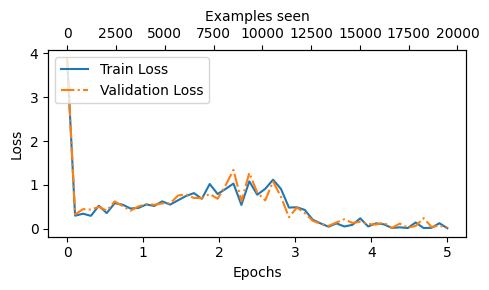

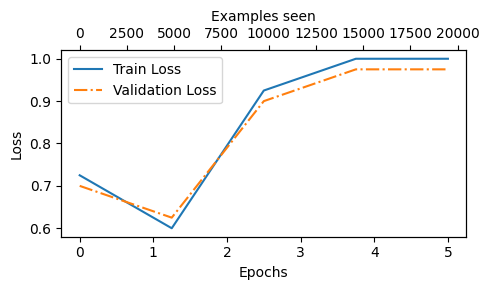

In [126]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_values(epochs_seen, examples_seen, train_losses, val_losses, label):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  if not isinstance(train_losses[0], float):
    # train_losses = [l.numpy() for l in train_losses]
    # val_losses = [v.numpy() for v in val_losses]
  # else:
    # Copy from mps to cpu
    train_losses = [l.cpu().numpy() for l in train_losses]
    val_losses = [v.cpu().numpy() for v in val_losses]

  ax1.plot(epochs_seen, train_losses, label="Train " + label)
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation " + label)
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper left")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_losses, alpha=0)
  ax2.set_xlabel("Examples seen")

  fig.tight_layout()
  #plt.savefig("ft-loss-plot.pdf")
  plt.show()

# Loss Plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, "Loss")

# Accuracy Plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, "Loss")


In [127]:
# Print the loss and accuracy on all the dataset
torch.manual_seed(123)

with torch.no_grad():
  train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
  validation_accuracy = calc_accuracy_loader(validation_loader, gpt, device)
  test_accuracy = calc_accuracy_loader(test_loader, gpt, device)

  train_loss = calc_loss_loader(train_loader, gpt, device)
  validation_loss = calc_loss_loader(validation_loader, gpt, device)
  test_loss = calc_loss_loader(test_loader, gpt, device)

print(f"train accuracy: {train_accuracy}\nvalidation accuracy: {validation_accuracy}\ntest_accuracy: {test_accuracy}")
print("")
print(f"train loss: {train_loss}\nvalidation loss: {validation_loss}\ntest loss: {test_loss}")


train accuracy: 0.9825462012320328
validation accuracy: 0.9730700179533214
test_accuracy: 0.9757847533632287

train loss: 0.04734570160508156
validation loss: 0.06894724071025848
test loss: 0.054030850529670715


# Use the model

In [128]:
def classify_message(message, model, tokenizer, device, max_length=None, pad_token_id=50256):
  model.eval()

  input_ids = tokenizer.encode(message)
  supported_context_length = model.pos_emb.weight.shape[0]

  input_ids = input_ids[:min(max_length, supported_context_length)]

  input_ids += [pad_token_id] * (max_length - len(input_ids))
  input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

  with torch.no_grad():
    logits = model(input_tensor)[:, -1, :]
  predicted_label = torch.argmax(logits, dim=-1).item()

  return 'spam' if predicted_label == 1 else 'not spam'

In [135]:
test_messages = [
    "Congratulations! You will receive a $2000 award",
    "Hey Jesscia, how are you?",
    "",
    "pls share hour feedback about your recent in Person visit at Google Premise Health",
    "Hello, I'm Judy from the ebay recruiting team",
    "Free sample if you click the button",
]

for m in test_messages:
  print(m, " = ", classify_message(m, gpt, tokenizer, device, max_length=train_dataset.max_length))

Congratulations! You will receive a $2000 award  =  spam
Hey Jesscia, how are you?  =  not spam
  =  not spam
pls share hour feedback about your recent in Person visit at Google Premise Health  =  not spam
Hello, I'm Judy from the ebay recruiting team  =  not spam
Free sample if you click the button  =  not spam
